In [2]:
# Are there any correlation to the month/day/season for absences?
# Which employee took the least amount of days off? Which took the most?
# Which age group are susceptible to absenteeism?
# Are there any relation to absences with BMI?
# What about social drinkers and smokers? Do they affect absenteeism?

In [3]:
# Initialization

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('ticks')
pd.options.display.max_columns = None

In [4]:
# Load the dataset

df = pd.read_csv('Dataset\Absenteeism_at_work.csv', delimiter=';')
df.head()

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
0,11,26,7,3,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,4
1,36,0,7,3,1,118,13,18,50,239.554,97,1,1,1,1,0,0,98,178,31,0
2,3,23,7,4,1,179,51,18,38,239.554,97,0,1,0,1,0,0,89,170,31,2
3,7,7,7,5,1,279,5,14,39,239.554,97,0,1,2,1,1,0,68,168,24,4
4,11,23,7,5,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,2


## 1: What are the top 5 reasons that employees are taking the day off for?


In [5]:
# Absences are coded based on the International Code of Diseases (ICD) for categories 1 to 21.
# An additional 7 categories that are not on the ICD are included (categories 22-28).

# Dict for the categories in 'Reason for absence' column in df

icd_dict = {0:'Unspecified', 
            1:'Certain infectious and parasitic diseases',
            2:'Neoplasms',
            3:'Diseases of the blood and blood-forming organs and certain disorders involving the immune mechanism',
            4:'Endocrine, nutritional and metabolic diseases',
            5:'Mental and behavioural disorders',
            6:'Diseases of the nervous system',
            7:'Diseases of the eye and adnexa',
            8:'Diseases of the ear and mastoid process',
            9:'Diseases of the circulatory system',
            10:'Diseases of the respiratory system',
            11:'Diseases of the digestive system',
            12:'Diseases of the skin and subcutaneous tissue',
            13:'Diseases of the musculoskeletal system and connective tissue',
            14:'Diseases of the genitourinary system',
            15:'Pregnancy, childbirth and the puerperium',
            16:'Certain conditions originating in the perinatal period',
            17:'Congenital malformations, deformations and chromosomal abnormalities',
            18:'Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified',
            19:'Injury, poisoning and certain other consequences of external causes',
            20:'External causes of morbidity and mortality',
            21:'Factors influencing health status and contact with health services.',
            22:'Patient follow-up',
            23:'Medical consultation',
            24:'Blood donation',
            25:'Laboratory examination',
            26:'Unjustified absence',
            27:'Physiotherapy',
            28:'Dental consultation'}


In [6]:
# Replace numerical values with categorical labels

df_reason = df['Reason for absence'].replace(icd_dict)

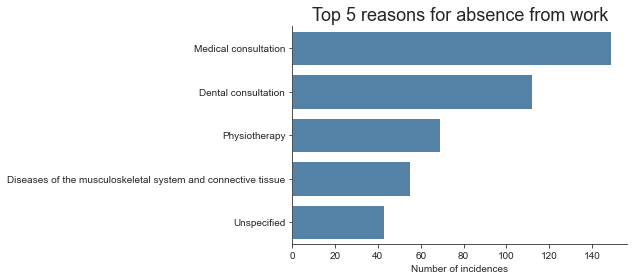

In [80]:
# Top 5 reasons for absence

top5_reason = df_reason.value_counts().head()

sns.barplot(y=top5_reason.index, x=top5_reason, color='steelblue', ci=None)
sns.despine()
plt.title('Top 5 reasons for absence from work', fontdict={'fontsize':18})
plt.xlabel('Number of incidences')
plt.show()


### Medical and dental consultations rank top among the reasons for absences of the period from Jul 2007 to Jul 2010. Not surprisingly, physiotherapy and diseases of the musculoskeletal system/connective tissue rank high at 3<sup>rd</sup> and 4<sup>th</sup> respectively! 

### Working in a courier service is a physically demanding job and injuries involving the neck, back and upper extremities are the among the most frequent.<sup>1,2</sup>

<sub>1. Smith CK, Williams J. Work related injuries in Washington State's Trucking Industry, by industry sector and occupation. Accident Analysis & Prevention. 2014 Apr 1;65:63-71.</sub><br>
<sub>2. Dennerlein JT, Meeker JD. Occupational injuries among Boston bicycle messengers. American journal of industrial medicine. 2002 Dec;42(6):519-25.</sub>

## 2.1: Are there any seasonal trend for absences?

In [8]:
# Data integrity check of month of absence vs seasons 
season_check = df.drop_duplicates(subset=['Month of absence','Seasons'])
season_check = season_check[['Month of absence','Seasons']].sort_values(by=['Month of absence','Seasons'])

# Drop where month of absence == 0, since it is not specified
season_check[season_check['Month of absence'] > 0]


,Month of absence,Seasons
113,1,2
137,2,2
155,3,2
175,3,3
184,4,3
204,5,3
234,6,1
220,6,3
0,7,1
19,8,1


According to https://seasonsyear.com/Brazil, 
- Spring months = 9, 10, 11
- Summer months = 12, 1, 2
- Autumn months = 3, 4, 5
- Winter months = 6, 7, 8

Some months exist in 2 seasons(i.e. month 3 is in season 2 & 3), which I assume is because the change in season falls somewhere in the middle of the month.

Going by the seasonal months listed on the website and allowing for some leeway in the overlap of seasons, the seasons and their corresponding numbers are decided as such:

In [67]:
season_dict = {1:'Winter',
               2:'Summer',
               3:'Autumn',
               4:'Spring'}

season_mths = {1:'Summer',
               2:'Summer',
               3:'Autumn',
               4:'Autumn',
               5:'Autumn',
               6:'Winter',
               7:'Winter',
               8:'Winter',
               9:'Spring',
               10:'Spring',
               11:'Spring',
               12:'Summer'}

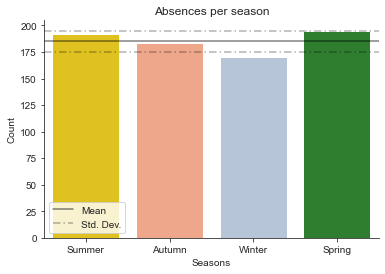

In [65]:
# Calculating the number of absences per season

abs_season = df.groupby(df['Seasons']).size()
abs_season = abs_season.reset_index().rename(columns={0:'Count'})
abs_season['Seasons'].replace(season_dict, inplace=True)

# Calculating the mean and standard deviation of the seasonal absences
mean_abs_sea = float(abs_season.mean())
sd_abs_sea = float(np.std(abs_season))

# Plotting figure
sea_labels = ['Summer','Autumn','Winter','Spring']
colors = sns.color_palette(['gold','lightsalmon','lightsteelblue','forestgreen'])

seaPlot = sns.barplot(x='Seasons', y='Count', data=abs_season, order=sea_labels, palette=colors)
seaPlot.axhline(mean_abs_sea, color='black', alpha=0.5, label='Mean')
seaPlot.axhline(mean_abs_sea + sd_abs_sea, color='black', alpha=0.3, dashes=(5,2,1,2), label= 'Std. Dev.')
seaPlot.axhline(mean_abs_sea - sd_abs_sea, color='black', alpha=0.3, dashes=(5,2,1,2))
sns.despine()
plt.legend()
plt.title('Absences per season')
plt.show()

It does not seem like there are much differences in absences between seasons between 2007-2010. How about the months?

## 2.2: Are there any monthly trend for absences?

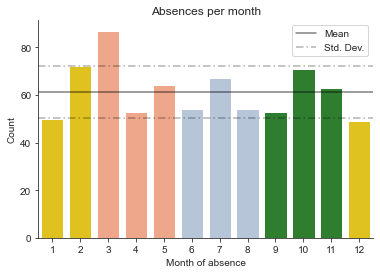

In [79]:
# Calculating the number of absences per month
abs_mth = df.groupby(df['Month of absence']).size()

# Dropping index 0 from 'Month of absence' as it was not specified
abs_mth = abs_mth.drop(0)

# Reconverting it back into dataframe and renaming the count column as 'Count'
# Months are also linked to seasons for plotting
abs_mth = abs_mth.reset_index().rename(columns={0:'Count'})
abs_mth['Seasons'] = abs_mth['Month of absence'].map(season_mths)

# Calculating the mean and standard deviation of the monthly absences
mean_abs_mth = abs_mth.mean()[1]
sd_abs_mth = np.std(abs_mth)[1]

# Color map to group the months by seasons 
color_map = dict(zip(sea_labels, colors))

# Plotting figure and horizontal lines for mean and stdev
mthPlot = sns.barplot(x='Month of absence', y='Count', data=abs_mth, palette=abs_mth['Seasons'].map(color_map))
mthPlot.axhline(mean_abs_mth, color='black', alpha=0.5, label='Mean')
mthPlot.axhline(mean_abs_mth+sd_abs_mth, color='black', alpha=0.3, dashes=(5,2,1,2), label= 'Std. Dev.')
mthPlot.axhline(mean_abs_mth-sd_abs_mth, color='black', alpha=0.3, dashes=(5,2,1,2))
sns.despine()
plt.legend()
plt.title('Absences per month')
plt.show()

## March stands out among the other months with the highest number of absences, well above the mean by approximately 42%! 

Perhaps the celebrations (i.e. Carnival Rio de Janeiro, Good Friday & Easter Sunday) in February and March has taken a toll on the health of the employees?

<sub>'Events in March' - https://www.kimkim.com/c/brazil-in-march-travel-tips-weather-and-more</sub>

In [150]:
# TBC, looking at most commmon absentee reason for each employee

# for item, group in df[['ID','Reason for absence']].groupby(df['ID']):
#     print(item)
    # print(group)

df.groupby(['ID','Reason for absence']).size()

ID  Reason for absence
1   0                      1
    1                      1
    7                      1
    11                     1
    13                     3
                          ..
36  14                     2
    19                     2
    23                    11
    26                     1
    28                     4
Length: 251, dtype: int64